<a href="https://colab.research.google.com/github/svsamsonov/ex2mcmc_new/blob/master/colab_notebooks/flex2mcmc_funnel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
!pip install ex2mcmc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [132]:
from typing import Optional
from pathlib import Path
import numpy as np
import torch
from torch.distributions import MultivariateNormal as MNormal, Normal
from matplotlib import pyplot as plt
import seaborn as sns

from ex2mcmc.samplers import flex2mcmc, ex2mcmc
from ex2mcmc.models.rnvp_minimal import MinimalRNVP
from ex2mcmc.models.rnvp import RNVP
from ex2mcmc.utils.general_utils import IMGS_DIR, random_seed

from ex2mcmc.pyro_samplers import NUTS, HMC

sns.set_theme('talk', style="white")

In [133]:
from typing import Iterable, List

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde


def ema(series: Iterable, n: int) -> List:
    """
    returns an n period exponential moving average for
    the time series
    """
    series = np.array(series)
    ema = []
    j = 1

    # get n sma first and calculate the next n period ema
    sma = sum(series[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    # EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(((series[n] - sma) * multiplier) + sma)

    # now calculate the rest of the values
    for i in series[n + 1 :]:
        tmp = ((i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)

    return ema

def plot_result(
    chains, dist, flow=None, chain_id=0, grid_n=100, proj_dim1=-1, proj_dim2=-2
):
    proj_slice = [proj_dim1, proj_dim2]
    proj_dim1 = dist.dim + proj_dim1 + 1 if proj_dim1 < 0 else proj_dim1 + 1
    proj_dim2 = dist.dim + proj_dim2 + 1 if proj_dim2 < 0 else proj_dim2 + 1

    if flow:
        fig, axs = plt.subplots(1, 4, figsize=(17, 4))
    else:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    result = chains.reshape(-1, chains.shape[-1])
    dist.plot_2d_countour(axs[0])
    xmin, xmax = axs[0].get_xlim()
    ymin, ymax = axs[0].get_ylim()

    axs[0].scatter(
        *result[:, proj_slice].T, alpha=min(0.6, 1000.0 / result.shape[0]), s=10
    )  # , c='r', marker='o')
    axs[0].set_title(f"Projected samples from {chains.shape[1]} chains")

    kernel = gaussian_kde(result[:, proj_slice].T)
    x = np.linspace(xmin, xmax, grid_n)
    y = np.linspace(ymin, ymax, grid_n)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    kde = np.reshape(kernel(positions).T, X.shape)
    axs[1].contour(X, Y, kde, cmap="inferno")
    axs[1].set_title(f"KDE")

    chain_id = 0
    result = chains[:, chain_id]
    dist.plot_2d_countour(axs[2])
    axs[2].plot(
        *result[:, proj_slice].T, "-", alpha=min(0.6, 1000.0 / result.shape[0])
    )  # , c='k')
    axs[2].set_title(f"Trajectory of chain {chain_id}")

    if flow:
        flow_sample = flow.sample((10000,)).detach().cpu()
        kernel = gaussian_kde(flow_sample[:, proj_slice].T)
        kde = np.reshape(kernel(positions).T, X.shape)
        axs[3].contour(X, Y, kde, cmap="inferno")
        axs[3].set_title(f"KDE of NF samples")

    for ax in axs:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_xlabel(rf"$X{proj_dim1}$")
        ax.set_ylabel(rf"$X{proj_dim2}$")

    fig.tight_layout()

In [134]:
N_CHAINS = 1
N_SAMPLES = 5000
BURN_IN = 1000

PROJ_DIM1 = -1
PROJ_DIM2 = -2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [135]:
class Funnel(object):
    """
    Funnel distribution.

    “Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

    Args:
        dim - dimension
        nu - parameter
    """
    def __init__(self, dim: int, a: float=3):
        self._dim = dim
        self.a = a
        self.normal_last = Normal(0, a)

    @property
    def dim(self) -> int:
        return self._dim
    
    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """

        normal_first = Normal(torch.zeros(x.shape[:-1], device=x.device), torch.exp(x[..., -1] / 2.))
        return normal_first.log_prob(x[..., :-1].permute(-1, *range(x.ndim-1))).sum(0) + \
            self.normal_last.log_prob(x[..., -1])

    def plot_2d_countour(self, ax):
        x = np.linspace(-15, 15, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])

        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))
        ax.contour(Y, X, Z.exp(), 
                   #levels = levels,
                   levels=3, 
                   alpha=1., cmap='inferno')


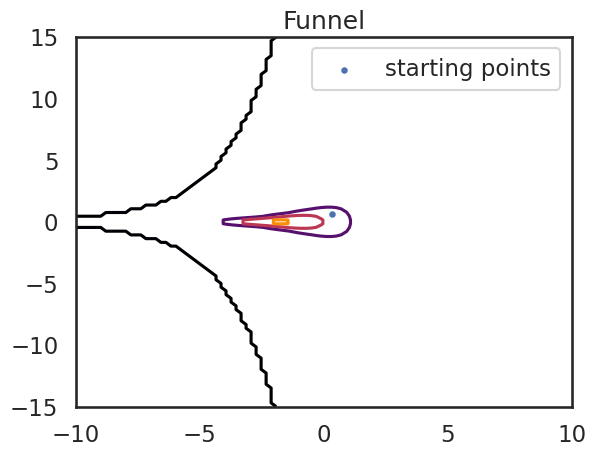

In [136]:
dim = 100
funnel = Funnel(dim=dim, a=2)
ax = plt.subplot()
funnel.plot_2d_countour(ax)

random_seed(42)
start_funnel = torch.randn((N_CHAINS, funnel.dim))
proj_slice = [-2, -1]
plt.scatter(*start_funnel[:, proj_slice].T, s=10, label='starting points')
plt.title('Funnel')
plt.legend()
plt.show()

In [ ]:
step_size = 0.1

random_seed(42)

chains = NUTS(start_funnel.to(device), funnel, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

Sample:  18%|█▊        | 1095/6000 [01:25, 23.57it/s, step size=1.01e-01, acc. prob=0.944]

In [ ]:
plot_result(chains.cpu(), funnel, proj_dim1=PROJ_DIM1, proj_dim2=PROJ_DIM2)

In [ ]:
chains = chains.cpu()
plt.scatter(chains.view(-1, dim)[:, PROJ_DIM1], chains.view(-1, dim)[:, PROJ_DIM2], alpha=0.3)
plt.title(r'NUTS samples')

In [ ]:
step_size = 0.1
n_particles = 2000
n_mala_steps = 3

proposal = MNormal(torch.zeros(dim, device=device), 1 ** 2 * torch.eye(dim, device=device))

chains, meta = ex2mcmc(
    start_funnel.to(device), 
    funnel, 
    proposal, 
    N_SAMPLES,
    BURN_IN,
    step_size=step_size, 
    n_particles=n_particles, 
    n_mala_steps=n_mala_steps, 
    verbose=True)
chains = chains.detach().cpu()

In [ ]:
plot_result(chains, funnel, proj_dim1=PROJ_DIM1, proj_dim2=PROJ_DIM2)

In [ ]:
plt.scatter(chains.view(-1, dim)[:, PROJ_DIM1], chains.view(-1, dim)[:, PROJ_DIM2], alpha=0.3)
plt.title(r'Ex$^2$MCMC samples')

In [ ]:
step_size = 0.1
target_acceptance = 0.67
n_particles = 200
n_mala_steps = 5
train_steps = 500
batch_size = 300
prior_scale = 1
backward_kl_weight = 0.05
forward_kl_weight = 1 - backward_kl_weight

proposal = RNVP(num_blocks=4, dim=dim, device=device, scale=prior_scale)
opt = torch.optim.Adam(proposal.parameters(), 1e-4)
proposal.optim = opt
proposal.train()
proposal.scheduler = torch.optim.lr_scheduler.LambdaLR(
    opt, lambda it: int(it < train_steps)
)

random_seed(42)

# train
_, meta = flex2mcmc(
    proposal.prior.sample((batch_size,)),
    funnel, 
    proposal, 
    1,
    train_steps,
    step_size=step_size, 
    n_particles=10,
    n_mala_steps=n_mala_steps,
    forward_kl_weight=forward_kl_weight,
    backward_kl_weight=backward_kl_weight,
    target_acceptance=target_acceptance,
    verbose=True)

proposal.eval();

In [ ]:
step_size = meta['step_size'][-1]
print(step_size)

In [ ]:
sample = proposal.sample((10000,)).detach().cpu()
plt.scatter(sample.view(-1, dim)[:, PROJ_DIM1], sample.view(-1, dim)[:, PROJ_DIM2], alpha=0.3)
plt.title('NF samples')

In [ ]:
# sample
# step_size = 0.1

chains, meta = flex2mcmc(
    start_funnel.to(device), 
    funnel, 
    proposal, 
    N_SAMPLES,
    BURN_IN,
    step_size=step_size, 
    n_particles=n_particles, 
    n_mala_steps=n_mala_steps, 
    target_acceptance=None, #target_acceptance,
    verbose=True)
chains = chains.detach().cpu()

In [ ]:
plot_result(chains.cpu(), funnel, proposal, proj_dim1=PROJ_DIM1, proj_dim2=PROJ_DIM2)

In [ ]:
plt.plot(ema(meta['sir_accept'], 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')
plt.show()

In [ ]:
plt.scatter(chains.view(-1, dim)[:, PROJ_DIM1], chains.view(-1, dim)[:, PROJ_DIM2], alpha=0.3)
plt.title(r'FlEx$^2$MCM samples')